In [62]:
pip install matplotlib pandas numpy datetime jupyterlab python-dotenv 

Note: you may need to restart the kernel to use updated packages.


In [58]:
#use data from lesson

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)


# Define folder paths relative to this notebook
raw_dir = 'data/raw'
processed_dir = 'data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

ModuleNotFoundError: No module named 'sklearn'

In [59]:
def detect_outliers_iqr(series: pd.Series, iqr_mult: float = 1.5) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce") 
    #coerce -->values cant convert to number are replaced by NaN, not considered into any future formulas
    # s = all values shoul be numbers or NaN
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr_mult * iqr
    upper = q3 + iqr_mult * iqr
    return (s < lower) | (s > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    mu = s.mean()
    stdev = s.std(ddof=0)
    if stdev == 0 or np.isnan(stdev):
        return pd.Series(False, index=s.index)
    z = (s - mu) / stdev
    return z.abs() > threshold
    
    
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    if not (0 <= lower < upper <= 1):
        raise ValueError("Quantiles must satisfy 0 <= lower < upper <= 1")
        
    s = pd.to_numeric(series, errors="coerce")
    low = s.quantile(lower)
    high = s.quantile(upper)
    return s.clip(lower=low, upper=high)

In [66]:
#DATA_PATH = Path('data/raw/outliers_homework.csv')
DATA_PATH = Path("data/raw/coco.csv")
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

RNG = np.random.default_rng(seed=17)
#seed=17 --> ensure same value will be created when running the code
#its like a locker that stores these values

def make_synthetic(n=500, outlier_frac=0.05, noise_std=1.0, rng=RNG):
    #make_synthetic(number of value, edge_outlier, within this stdev, 
    
    x = rng.normal(0.0,noise_std , n) #normal distribution
    
    y = 3.0 * x + rng.normal(0, noise_std, n)
    
    k = int(n * outlier_frac)
    
    if k > 0:
        idx = rng.choice(n, size=k, replace=False)
        # randomly selects some value (0 to n) not inclusive 

        #replace these values
        x[idx] = x[idx] * rng.integers(6, 12, size=k) + rng.normal(0, 5, size=k)
        y[idx] = y[idx] * rng.integers(6, 12, size=k) + rng.normal(0, 8, size=k)
        
    return pd.DataFrame({"x": x, "y": y})

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
else:
    df = make_synthetic()
    df.to_csv(DATA_PATH, index=False)
    source = "synthetic (saved to CSV)"

print(f"Data shape: {df.shape} — {source}")
df.head()


Data shape: (500, 2) — synthetic (saved to CSV)


,x,y
0,1.101262,4.248333
1,0.338431,2.095149
2,-0.539972,-3.113905
3,-1.260242,-5.801234
4,-1.894621,-5.222242


In [74]:
target_row = 'x'
target_col = 'y'

In [67]:
#Create outlier flags

#from src.outlier import detect_outliers_iqr, detect_outliers_zscore, winsorize_series

# Outlier masks
mask_iqr = detect_outliers_iqr(df[target_col])
mask_z   = detect_outliers_zscore(df[target_col], threshold=3.0)

# Values flagged by each method
outliers_iqr = df.loc[mask_iqr, target_col]
outliers_z   = df.loc[mask_z, target_col]

print("IQR outlier values:\n", outliers_iqr.to_list())
print("\nZ-score outlier values:\n", outliers_z.to_list())


IQR outlier values:
 [-9.38811841712654, 51.30017138260258, -33.5682429009469, 8.613094907722369, -50.763694709786066, 27.43548166833898, 9.996739408827992, 8.739326752343533, -12.713549281979345, 21.214691651335528, -10.72134712073067, 57.82683953671922, 16.259260280486032, 25.07570015913494, 10.38405356005341, 13.65008959439611, 34.68858113328203, -8.590563091067352, -18.445503497056745, 45.337843171180346, -27.948723065572725]

Z-score outlier values:
 [51.30017138260258, -33.5682429009469, -50.763694709786066, 27.43548166833898, 21.214691651335528, 57.82683953671922, 25.07570015913494, 34.68858113328203, 45.337843171180346, -27.948723065572725]


In [68]:
#Class Code Comparison
target_col = 'daily_return' if 'daily_return' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.046
outlier_z      0.020
dtype: float64

## Sensitivity analysis

Fit a simple linear regression and compare coefficients/R2/MAE with vs. without outliers;
optionally include winsorized.

In [69]:
#class notes
# Summary stats for full, filtered, and winsorized data
def get_summary(series):
    return pd.Series({
        "mean": series.mean(),
        "median": series.median(),
        "std": series.std()
    })

# all data
summ_all = get_summary(df[target_col])

# filtered (no outliers)
summ_filtered = get_summary(df.loc[~df["outlier_iqr"], target_col])

# winsorized (if function exists)
summ_w = None
if "winsorize_series" in globals():
    w = winsorize_series(df[target_col])
    summ_w = get_summary(w)

# Combine into one table
comp = pd.concat(
    {
        "all": summ_all,
        "filtered_iqr": summ_filtered,
        **({"winsorized": summ_w} if summ_w is not None else {})
    },
    axis=1
)

print(comp)


             all  filtered_iqr  winsorized
mean   -0.106137     -0.052133   -0.058100
median -0.049663     -0.047480   -0.049663
std     2.086471      0.970897    1.000095


In [70]:
#  summary stats for all, filtered, and winsorized data
def simple_summary(series):
    return {"mean": series.mean(), "median": series.median(), "std": series.std()}

summaries = {
    "all": simple_summary(df[target_col]),
    "filtered_iqr": simple_summary(df.loc[~df["outlier_iqr"], target_col])
}

if "winsorize_series" in globals():
    summaries["winsorized"] = simple_summary(winsorize_series(df[target_col]))

# Convert to DataFrame for display
comp = pd.DataFrame(summaries)
print(comp)


             all  filtered_iqr  winsorized
mean   -0.106137     -0.052133   -0.058100
median -0.049663     -0.047480   -0.049663
std     2.086471      0.970897    1.000095


/var/folders/zp/cxqlz1xd78bcshll8_fr_byw0000gn/T/ipykernel_57388/1519556991.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


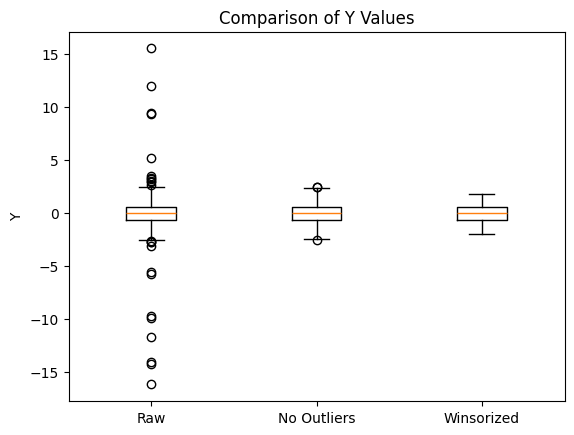

In [71]:
# Boxplot of y

y_raw = df[target_col]
y_no_outliers = df.loc[~df["outlier_iqr"], target_col]
y_winsor = winsorize_series(y_raw) if 'winsorize_series' in globals() else None


# Collect datasets for plotting
data = [y_raw, y_no_outliers]
labels = ["Raw", "No Outliers"]

if y_winsor is not None:
    data.append(y_winsor)
    labels.append("Winsorized")

# Box plot
plt.boxplot(data, labels=labels)
plt.title("Comparison of Y Values")
plt.ylabel("Y")
plt.show()



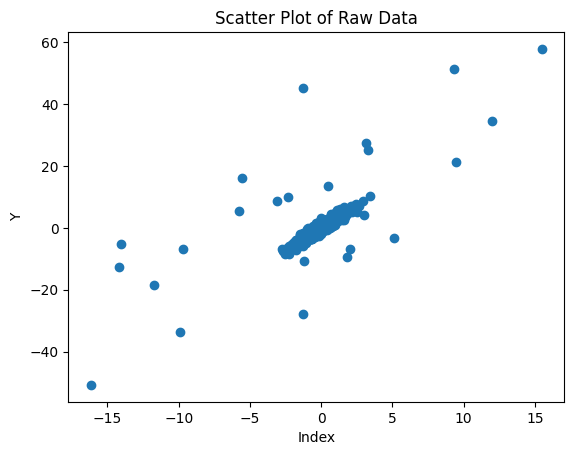

In [88]:
#Scatter plot (Outlier unlabled)


plt.scatter(df[target_row], df[target_col])
plt.title("Scatter Plot of Raw Data")
plt.xlabel("Index")
plt.ylabel("Y")
plt.show()


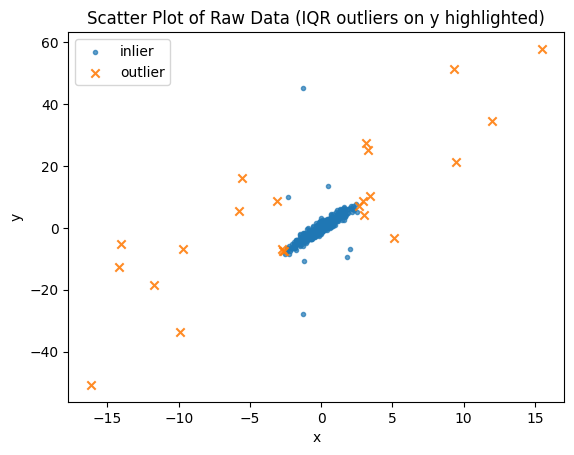

In [89]:
# Scatter Plot (Outlier highlighted)

#no outliers 
inliers = ~df["outlier_iqr"] #keeps only rows where outlier_iqr is False

plt.scatter(df.loc[inliers, target_row], df.loc[inliers, target_col], alpha=0.7, marker=".", label="inlier")
plt.scatter(df.loc[~inliers, target_row], df.loc[~inliers, target_col], alpha=0.9, marker="x", label="outlier")

plt.title("Scatter Plot of Raw Data (IQR outliers on y highlighted)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
plt.show()
